In [234]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [235]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [236]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [237]:
from datasets import load_dataset, Split

In [238]:
import torch.autograd as autograd

In [239]:
channels = 3 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4#0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 64
N_Epochs         = 1_000#4_000  ##27000  
num_classes = 3
pixels = 32
img_size = pixels*pixels*channels
certainty_repeater = 6# channels**2 - num_classes
print(f"{img_size=}")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps is not None:
    device = torch.device('mps')
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device=}")
device = 'cpu'

img_size=3072
device=device(type='mps')


In [240]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class MyDataset(VisionDataset):
    classes = [
        'sword',
        'pickaxe',
        'axe',
        'hoe',
        'shovel'
    ]

    def __init__(
        self,
        root: str = "mc-dataset.pkl",
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        self.data, self.targets = self._load_data()

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self):
        with open('mc-dataset.pkl', 'rb') as f:
            data = pickle.load(f)
        
        imgs = []
        labels = []
        for i in range(len(data)):
            imgs.append(torch.Tensor(data[i][0]))
            labels.append(data[i][1])

        # if self.train:
        #     data = data[0]
        # else:
        #     data = data[1]
        return imgs, labels

img.shape=torch.Size([32, 32, 3])


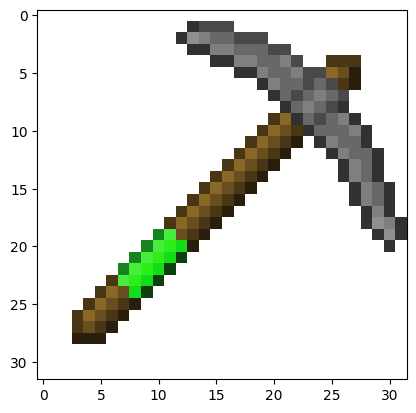

In [241]:
# df = pd.DataFrame(dataset.reshape((dataset.shape[0], 32*32)))
# df.to_csv(f"{data}-dataset.csv", index=False, header=False)

# load the dataset
dataset = MyDataset()

# load the first image in the dataset
# print(dataset[5][0])
img, label = dataset[5]
print(f"{img.shape=}")
img *= 255
plt.imshow(Image.fromarray(img.numpy().astype(np.uint8)))

In [242]:
# display the split of labels in the dataset
for i in range(5):
    print(f"Label {i}: {len([x for x in dataset.targets if x == i])}")

# convert the dataset into a train / test split
# TODO i dont think test is used
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])

# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Label 0: 68
Label 1: 51
Label 2: 49
Label 3: 0
Label 4: 0


In [243]:

def plot_GAN_losses(list_losses_fake):
    
    the_epochs = [i for i in range(len(list_losses_fake))]  

    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.legend() 
    plt.show()


In [244]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [245]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [246]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [247]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [248]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [249]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []

classes = [
    'sword',
    'pickaxe',
    'axe',
    'hoe',
    'shovel'
]

import tqdm

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    pbar = tqdm.tqdm(range(N_Epochs+1))

    for epoch in pbar:
        # shuffle dl_train every epoch
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb = xb.to(device), yb.to(device)

            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            if channels == 4 or channels == 3:
                xb = xb.permute(0, 3, 1, 2)
            xb = torch.squeeze(xb, dim=1)
            yb = F.one_hot(yb, num_classes=num_classes).repeat(1, certainty_repeater).to(device)

            yb_certainty = yb.repeat(channels, pixels, 1, 1).permute(2, 0, 1, 3) # [ batch, x (classes), y, channels ]
            real = torch.cat( (xb, yb_certainty) , dim=3)

            for _ in range(5):
                noise = torch.cat( (random_G_batch_vector_input(), yb) , dim=1)
                fake = G_model( noise )#.detach()

                real_pred = D_model( real  ).reshape(-1)
                
                inputs = torch.cat( (fake, yb_certainty) , dim=3)
                fake_pred = D_model(  inputs  ).reshape(-1)

                fake_loss   = D_loss_fn(D_model, inputs, real, real_pred, fake_pred)
                # D_opt.zero_grad()
                D_model.zero_grad()
                fake_loss.backward(retain_graph=True)
                D_opt.step()
                
            output = D_model( inputs ).reshape(-1)
            gen_loss = -torch.mean(output)
            G_model.zero_grad()
            gen_loss.backward()
            G_opt.step()
       
            
        if epoch % 1 == 0:
            list_losses_fake.append(        fake_loss.cpu().detach().numpy()  )
            D_fake_loss_rnd = np.round(fake_loss.cpu().detach().numpy(), 3)

            message = f"{D_fake_loss_rnd=}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        if epoch % 10 == 0:
            f, axarr = plt.subplots(nrows=1, ncols=num_classes, figsize=(12,4))
            
            for i in range(num_classes):
                label = torch.tensor([i]).to(device)
                label = F.one_hot(label, num_classes=num_classes)
                label = label.repeat(1, certainty_repeater)

                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).cpu()
                # convert output (batch, img_size) to (batch, 4, 32, 32)
                if channels == 4 or channels == 3:
                    # output = output.reshape((-1, 4, pixels, pixels)) # wrong too, lol
                    output = output.reshape((-1, channels, pixels, pixels))
                    # output = output.reshape((-1, 32, 32))

                    img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(32,32)
                elif channels == 1:
                    img = output.detach().numpy()

                if channels == 4 or channels == 3:
                    mode = None
                elif channels == 1:
                    mode = 'L'

                img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)
                # display the image
                axarr[i].imshow(img)
                # place name of class on image
                axarr[i].set_title(classes[i])
            plt.show()
            


In [250]:
def grad_penatly(critic, real, fake):
    # Random weight term for interpolation between real and fake samples
    batch, c, h, w = real.shape
    epsilon = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Take the norm of the gradient
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1) # L2 norm (euclidean norm)
    gradient_penalty = torch.mean((grad_norm - 1) ** 2)
    return gradient_penalty

In [251]:
def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    loss =  - (real_pred.mean() - fake_pred.mean()) + 10 * grad_penatly(D_model, real_data, gen_img)
    return loss

In [256]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 2, 2, 1),
            self._block(features_d * 2, features_d * 4, 2, 2, 1),
            self._block(features_d * 4, features_d * 8, 2, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=2, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)

  0%|          | 0/101 [00:00<?, ?it/s]

D_fake_loss_rnd=-0.45:   0%|          | 0/101 [00:02<?, ?it/s]/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_74698/927843797.py:95: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)


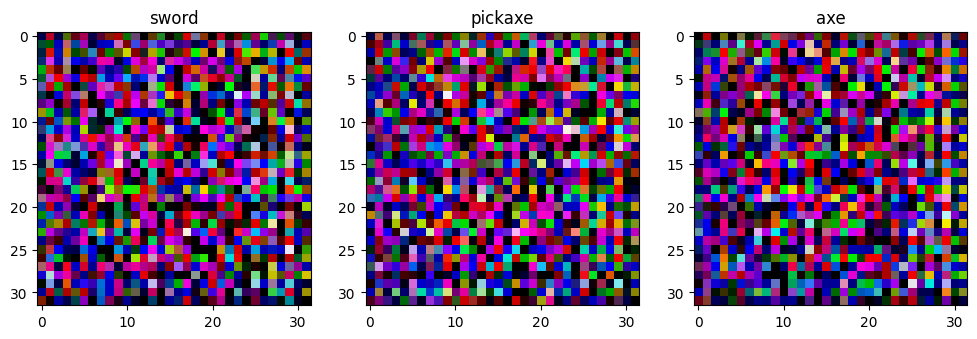

D_fake_loss_rnd=-12.727:  10%|▉         | 10/101 [00:27<03:42,  2.45s/it]

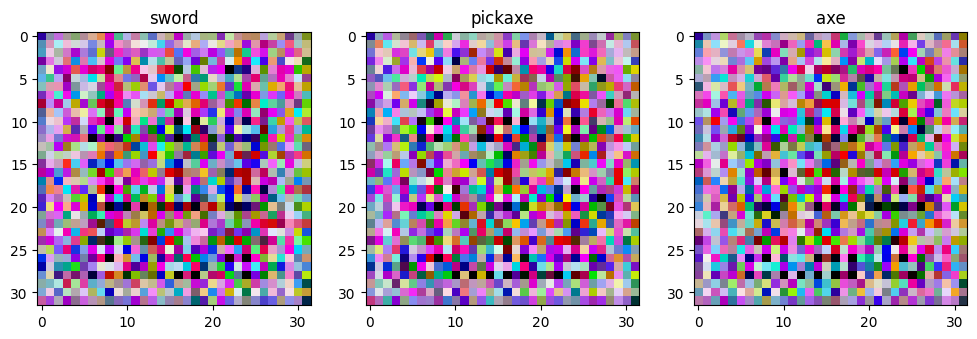

D_fake_loss_rnd=-8.601:  20%|█▉        | 20/101 [00:51<03:19,  2.46s/it] 

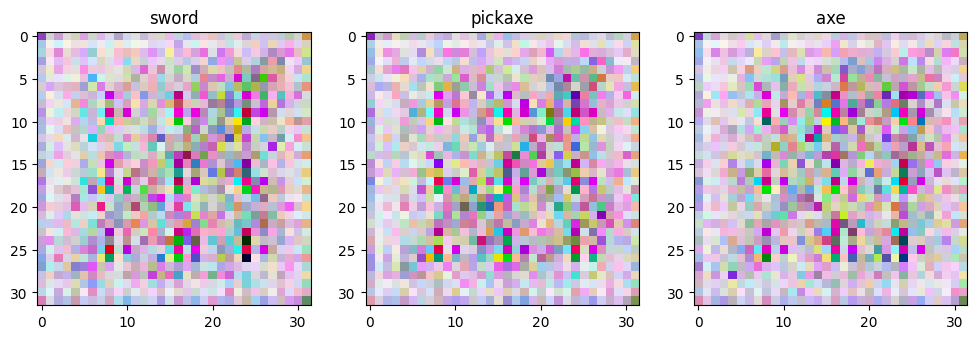

D_fake_loss_rnd=-5.851:  30%|██▉       | 30/101 [01:16<02:53,  2.45s/it]

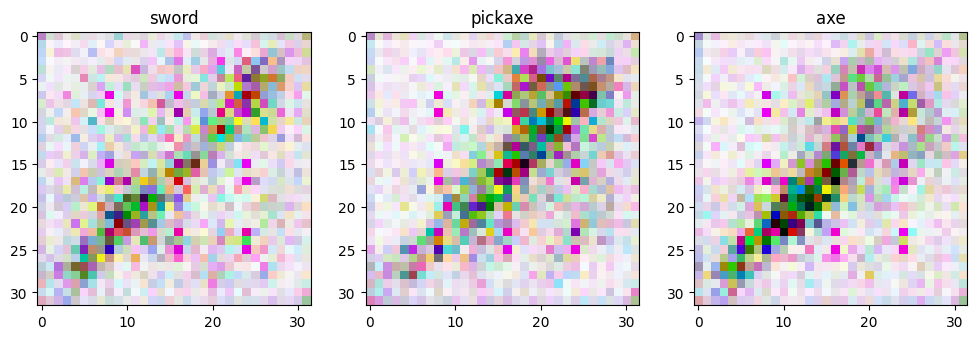

D_fake_loss_rnd=-4.341:  40%|███▉      | 40/101 [01:41<02:28,  2.44s/it]

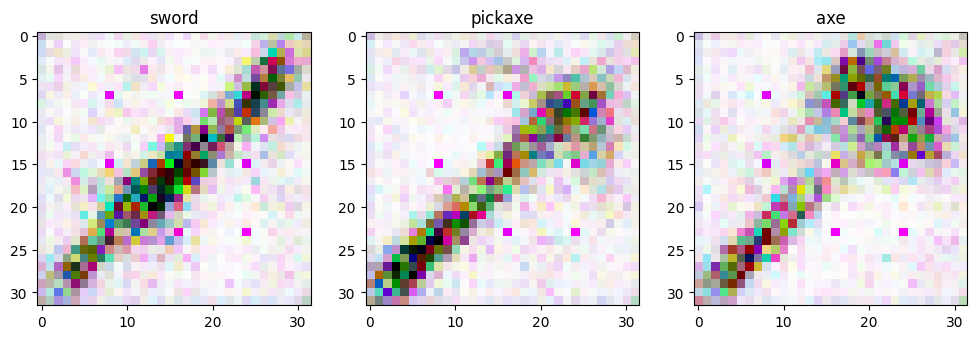

D_fake_loss_rnd=-2.832:  50%|████▉     | 50/101 [02:05<02:04,  2.44s/it]

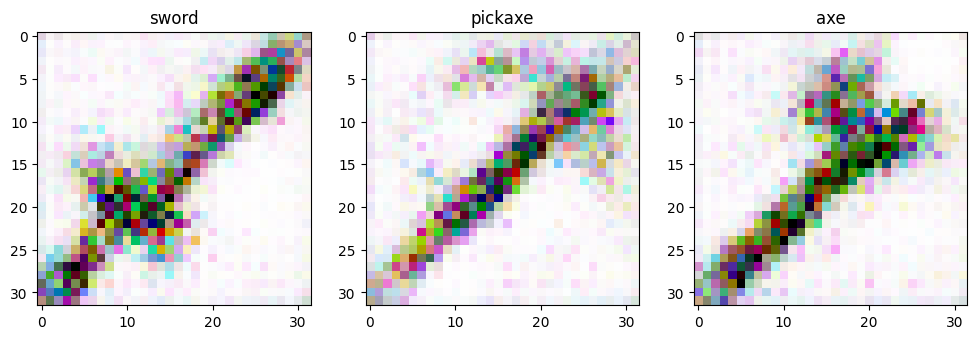

D_fake_loss_rnd=-2.759:  59%|█████▉    | 60/101 [02:30<01:39,  2.42s/it]

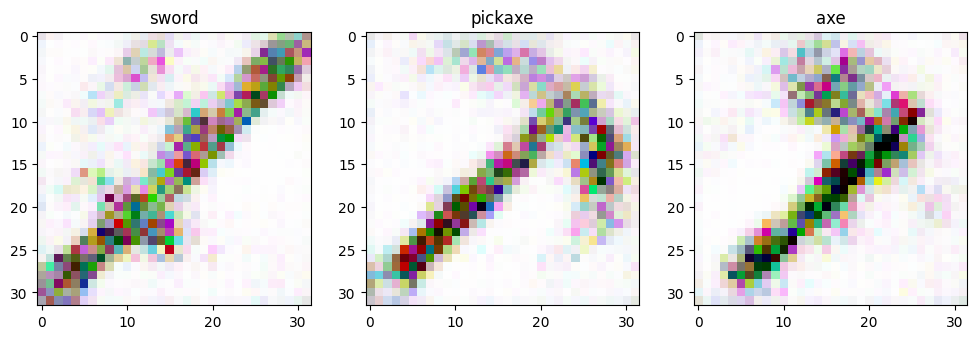

D_fake_loss_rnd=-2.768:  69%|██████▉   | 70/101 [02:55<01:15,  2.45s/it]

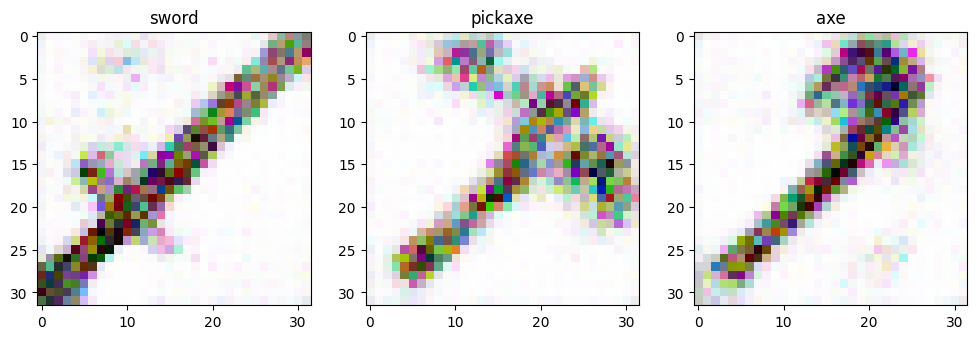

D_fake_loss_rnd=-2.579:  79%|███████▉  | 80/101 [03:20<00:51,  2.46s/it]

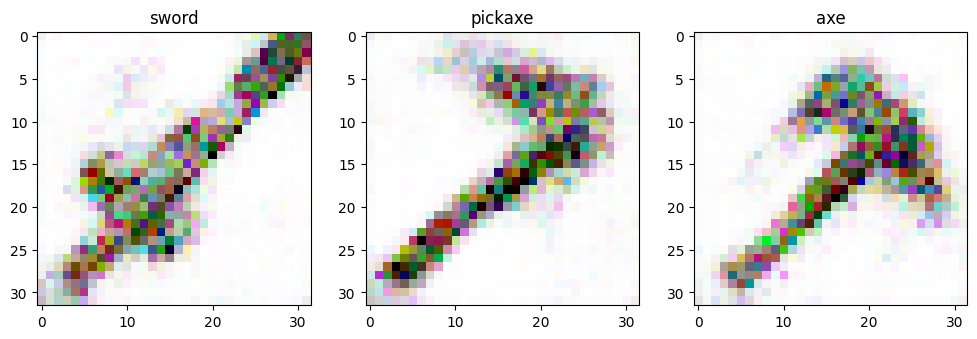

D_fake_loss_rnd=-2.979:  89%|████████▉ | 90/101 [03:45<00:27,  2.46s/it]

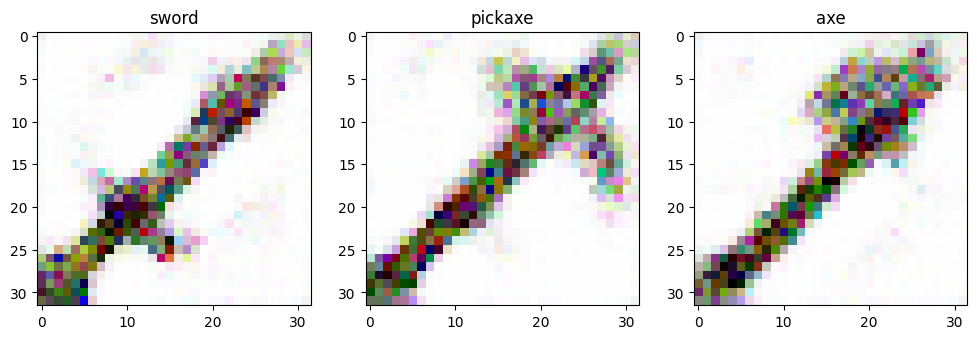

D_fake_loss_rnd=-2.773:  99%|█████████▉| 100/101 [04:56<00:04,  4.61s/it]

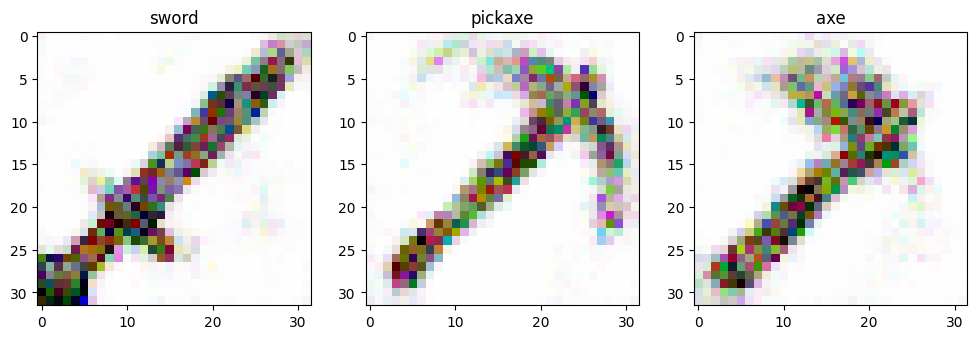

D_fake_loss_rnd=-2.773: 100%|██████████| 101/101 [04:57<00:00,  2.94s/it]


In [257]:
G_model     =  basic_generator(pixels, in_sz=100+num_classes*certainty_repeater, n_channels=channels, n_extra_layers=1)# Generator_Net()

# G_model     = Generator_DL_Net()

D_model     =    basic_critic(
                    pixels, 
                    n_channels=channels, 
                    n_extra_layers=1, 
                    act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
)#

D_model     = Critic(channels_img=channels, features_d=pixels)

# D_model = CriticNet()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn = wasserstein_loss
# use a loss function that supports values between -1 and 1
# D_loss_fn = nn.BCEWithLogitsLoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )

# move everything to device
G_model.to(device)
D_model.to(device)
# D_loss_fn.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )


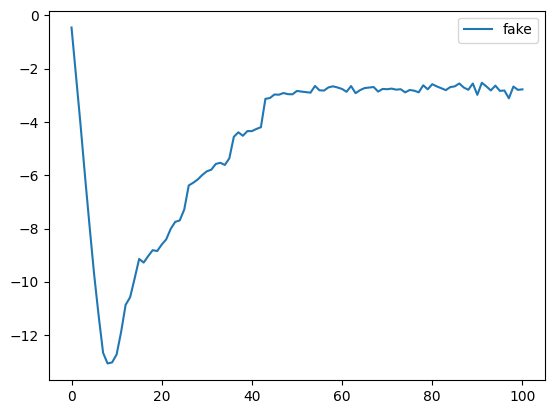

In [258]:
plot_GAN_losses(list_losses_fake)

In [259]:
label = 0
        
label_tensor = torch.zeros((num_classes)).to(device)
label_tensor[label] = 1.0

label_tensor = label_tensor.unsqueeze(0)
label_tensor = label_tensor.repeat(1, certainty_repeater)
print(label_tensor.shape)

# label_tensor = label_tensor.repeat(4, 32, 1).permute(0, 1, 2)
# label_tensor.shape

torch.Size([1, 18])


/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_74698/2723397247.py:20: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0])


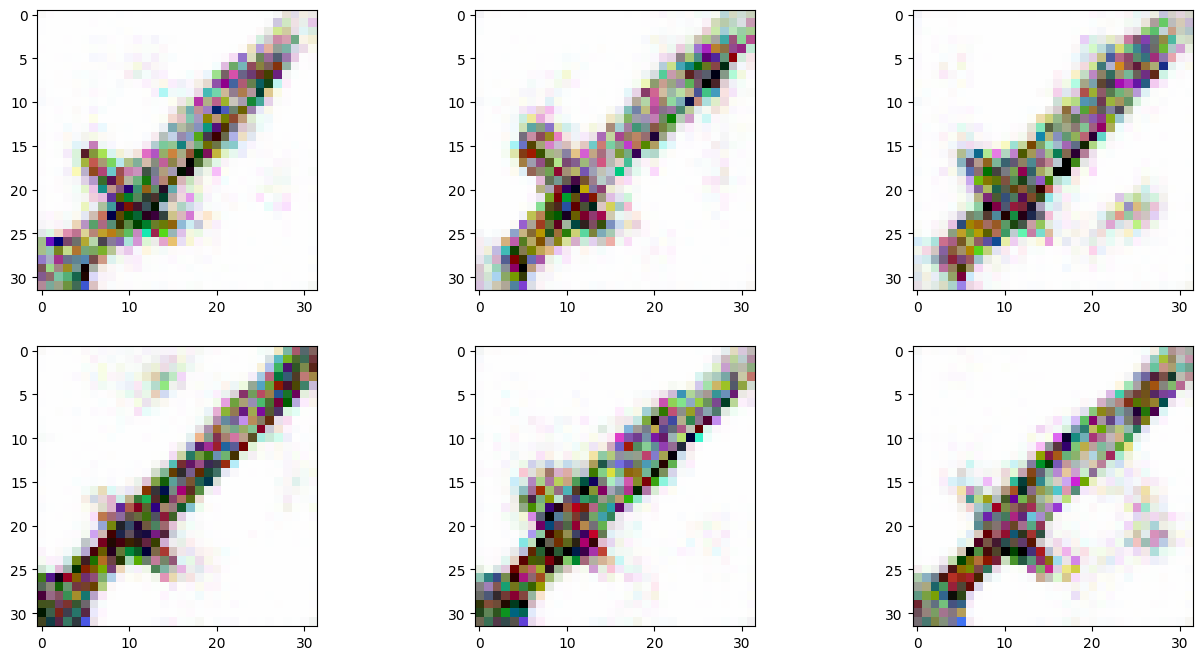

In [260]:
f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        rand = random_G_vector_input().unsqueeze(0)
        # print(rand.shape)

        inputs = torch.cat( (rand, label_tensor) , dim=1)
        output = G_model.forward( inputs).cpu()
        # convert output (batch, img_size) to (batch, 4, 32, 32)
        if channels == 4 or channels == 3:
            output = output.reshape((-1, channels, pixels, pixels))
            img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(pixels,pixels)
        elif channels == 1:
            output = output.reshape((-1, pixels, pixels))
            img = output.detach().numpy()

        # print(img.shape)
        # convert img to pil
        img = Image.fromarray((img * 255).astype(np.uint8)[0])
        # display the image
        # plt.imshow(img)
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues'